<a href="https://colab.research.google.com/github/ROPDIS/Models/blob/main/RESNET_LR0_002_Section5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Load the dependencies


In [ ]:
import numpy as np
import torch
import cv2 as cv2
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import os
from pathlib import Path
import glob
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC

Step 2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")




Mounted at /content/gdrive


Step 3: Import Images

In [ ]:
train_path = Path("/content/gdrive/MyDrive/Dis/Training Set Thumbnails")
test_path= Path("/content/gdrive/MyDrive/Dis/TestSetThumbnails")

test = Path('/content/gdrive/MyDrive/')







Training Data

In [ ]:
train_paths = list(train_path.glob(r"**/*.jpg"))




Testing Set

In [ ]:
test_paths = list(test_path.glob(r"**/*.jpg"))



Image Pre-processing


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(60,80),
                                        batch_size=32,
                                        class_mode='binary')


Found 17970 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(test_path, batch_size = 32,target_size=(60,80),class_mode='binary')

Found 1742 images belonging to 2 classes.


Calculating F-score

In [ ]:
def f_score(y_true, y_pred):
    true_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.backend.sum(K.backend.round(K.backend.clip(y_true, 0, 1)))
    predicted_positives = K.backend.sum(K.backend.round(K.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.backend.epsilon())
    recall = true_positives / (possible_positives + K.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.backend.epsilon())
    return f1_val

In [ ]:
# Custom Metric Functions
precision = Precision(name='precision')
recall = Recall(name='recall')
auc = AUC(name='auc')


CNN Model


In [ ]:
from tensorflow.keras.regularizers import L1

resnet = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(60,80,3),
                   pooling=None,classes=2)

for layer in pretrained_model.layers:
  layer.trainable=False

resnet.add(pretrained_model)

resnet.add(tf.keras.layers.GlobalMaxPooling2D())  # Use GlobalMaxPooling2D
resnet.add(BatchNormalization())  # Add BatchNormalization layer
resnet.add(tf.keras.layers.Dropout(0.2,activity_regularizer=L1(0.01))) #Add Dropout Layer
resnet.add(tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=L1(0.01)))
resnet.add(BatchNormalization())  # Add BatchNormalization layer
resnet.add(tf.keras.layers.Dropout(0.2,activity_regularizer=L1(0.01))) #Add Dropout Layer
resnet.add(tf.keras.layers.Dense(1, activation='sigmoid'))

resnet.summary()




94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 3, 2048)        23564800  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                         

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer_adam=Adam(learning_rate=0.002)

resnet.compile(optimizer=optimizer_adam, loss='binary_crossentropy', metrics=[precision, recall, auc, 'accuracy',f_score])

In [ ]:
history=resnet.fit(
    training_set,
    validation_data=test_set,
    epochs=45,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=25,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=4
        )
    ]
)




Epoch 1/45
562/562 [==============================] - 3137s 6s/step - loss: 15.6343 - precision: 0.7288 - recall: 0.7783 - auc: 0.7833 - accuracy: 0.7237 - f_score: 0.7494 - val_loss: 4.0478 - val_precision: 0.9238 - val_recall: 0.9162 - val_auc: 0.7358 - val_accuracy: 0.8548 - val_f_score: 0.9187 - lr: 0.0020
Epoch 2/45
562/562 [==============================] - 74s 132ms/step - loss: 3.3821 - precision: 0.7422 - recall: 0.8059 - auc: 0.8100 - accuracy: 0.7438 - f_score: 0.7696 - val_loss: 3.0630 - val_precision: 0.9323 - val_recall: 0.8500 - val_auc: 0.7215 - val_accuracy: 0.8071 - val_f_score: 0.8879 - lr: 0.0020
Epoch 3/45
562/562 [==============================] - 73s 130ms/step - loss: 3.1159 - precision: 0.7419 - recall: 0.7887 - auc: 0.8073 - accuracy: 0.7376 - f_score: 0.7615 - val_loss: 3.0981 - val_precision: 0.9364 - val_recall: 0.7883 - val_auc: 0.7165 - val_accuracy: 0.7583 - val_f_score: 0.8518 - lr: 0.0020
Epoch 4/45
562/562 [==============================] - 73s 129ms/

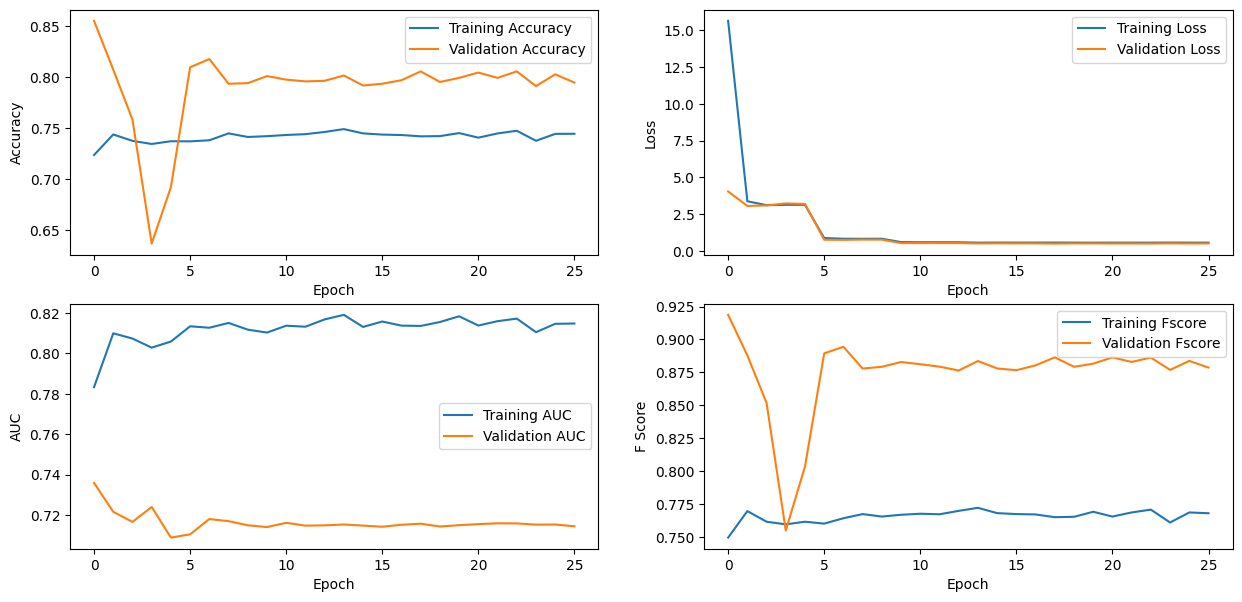

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy and loss
plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.subplot(2, 2, 4)
plt.plot(history.history['f_score'], label='Training Fscore')
plt.plot(history.history['val_f_score'], label='Validation Fscore')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F Score')

plt.show()